<img style="float:right" src="images/logo_va.png" /> 

# Visione Artificiale
## Esercitazione: Motion detection e object tracking

### Sommario
* Estrarre frame da un video memorizzato su file
* Calcolare l'istogramma dei valori Hue di una serie di immagini
* Individuare oggetti nei frame del video in base all'istogramma dei valori Hue
* Inseguire oggetti in un video

Iniziamo con l'importazione dei moduli che ci serviranno: `NumPy`, `OpenCV`, `va`. Importiamo anche la funzione `interact` di Jupyter.

In [2]:
import numpy as np
import cv2 as cv
import va
from ipywidgets import interact

<img style="float:left" src="images/ar.png" />**Esercizio 1** - Aprire il video "movimento/pacman.mp4"; creare una lista Python `frames` che contenga i frame (come matrici NumPy) di indice dispari dal 125 al 3523 (estremi compresi, numerando i frame del video a partire da 0).

In [3]:
# --- Svolgimento Esercizio 1: Inizio --- #

indx=0
frames = []
cap = cv.VideoCapture('movimento/pacman.mp4')
for j in range(125):
    cap.read()#salto i primi 125
for i in range(125,3524, 2): #solo dispari, va di due in due
    ret, frame = cap.read()
    cap.read()#salta frame pari (visto dal prof, non l'avrei fatto)s
    frames.append(frame)

cap.release()      

# --- Svolgimento Esercizio 1: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente consente di visualizzare il risultato ottenuto, scorrendo la lista `frames`. Per spostare il cursore di un frame per volta è possibile utilizzare i tasti 'Freccia sinistra' e 'Freccia destra' della tastiera.

In [4]:
@interact(i=(0,len(frames)-1))
def show_frame(i=0):
    va.show(frames[i])

interactive(children=(IntSlider(value=0, description='i', max=1699), Output()), _dom_classes=('widget-interact…

Eseguire la cella seguente per verificare che `frames` contenga il numero atteso di frame.

In [5]:
va.test_movimento_1(frames)

Verifica numero di frame nella lista
""


<img style="float:left" src="images/ar.png" />**Esercizio 2** - Creare un array `sprites` che contenga le immagini caricate dai file il cui nome è nell'array `sprite_names`, dalla cartella "movimento", con estensione "png". Una volta creato l'array `sprites`, procedere come segue:
* definire una variabile `OBJ_SIZE` contenente la larghezza della prima immagine in `sprites`;
* creare una lista di istogrammi `hists` in cui, per ciascuna immagine in `sprites`, dopo averla convertita in HSV, si calcola l'istogramma dei valori $H$ solo dei pixel con $S\geq20$ e $V\geq40$. L'istogramma dovrà essere un array NumPy con 15 valori, suddividendo i 180 possibili valori di $H$ in 15 gruppi da 12 valori ciascuno. Infine i valori degli istogrammi dovranno essere normalizzati fra 0 e 100. Ogni istogramma dovrà essere un array NumPy di 15 `np.float32`.

Suggerimenti: si può utilizzare `cv.CalcHist` per calcolare gli istogrammi sul canale H (è possibile passare il parametro `mask` per considerare solo determinati pixel e il parametro `histSize` per specificare la dimensione di 30 elementi desiderata). La normalizzazione può essere effettuata con la funzione OpenCV `cv.normalize`.

In [7]:
sprite_names=['F0','F1','F2','F3','P0']

# --- Svolgimento Esercizio 2: Inizio --- #

sprites = [cv.imread(f'movimento/{i}.png') for i in sprite_names]
OBJ_SIZE = sprites[0].shape[1]
tmp=[]


for s in sprites:
    hsv = (cv.cvtColor(s, cv.COLOR_BGR2HSV))
    mask= cv.inRange(hsv, (0,20,40), (179, 255,255))
    hist = cv.calcHist([hsv], [0], mask, [15], [0,180]).squeeze()#quadre perche?
    nor= cv.normalize(hist, hist, 0, 100, cv.NORM_MINMAX) 
    tmp.append(hist)
    
hists=np.float32(tmp)
    

# --- Svolgimento Esercizio 2: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente consente di visualizzare le immagini e i corrispondenti istogrammi. Se gli istogrammi sono stati calcolati correttamente, il colore che caratterizza ciascuna immagine dovrebbe essere ben visibile come picco nell'istogramma.

F0,F1,F2,F3,P0
,,,,

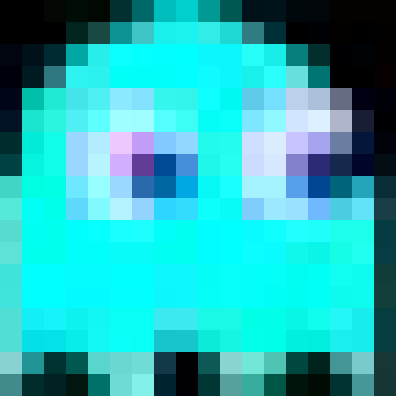
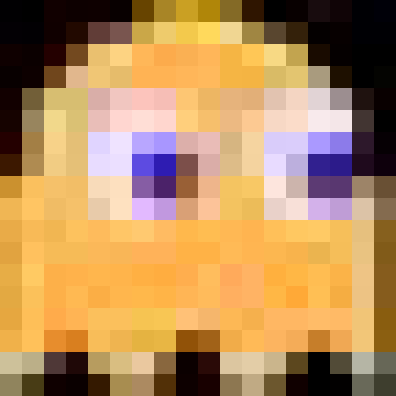
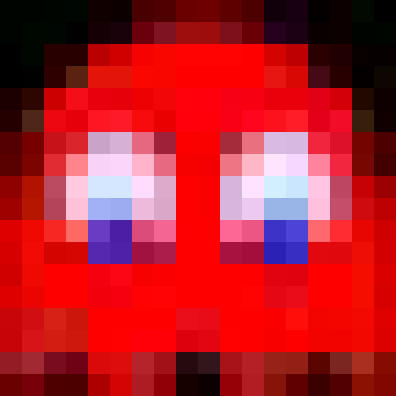
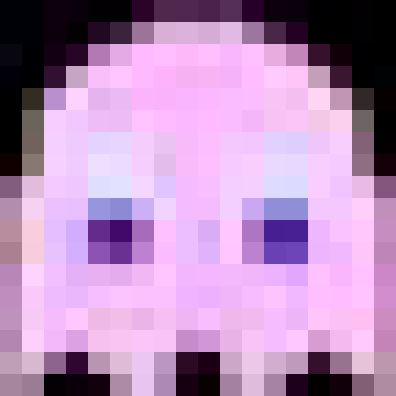
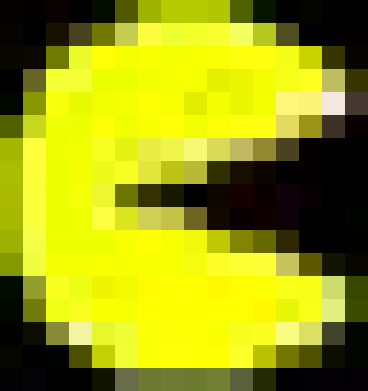

,,,,
,,,,

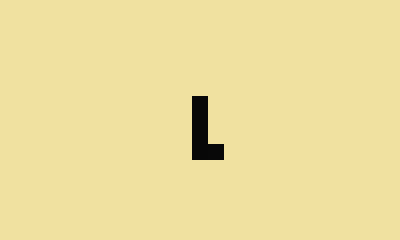
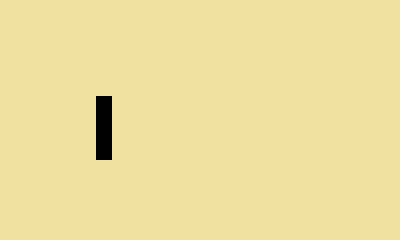
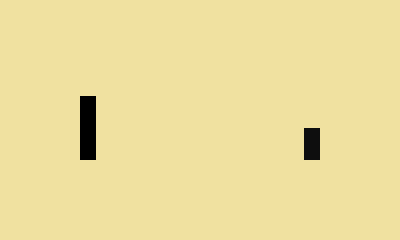
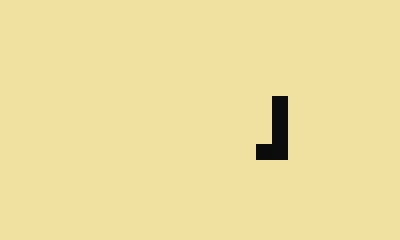
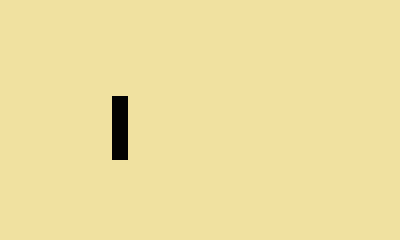

In [55]:
va.show(*zip(sprites,sprite_names))
va.show(*[va.draw_hist(h, height = 15) for h in hists])

Eseguire la cella seguente per verificare che `OBJ_SIZE` e `hists` siano stati calcolati correttamente.

In [56]:
va.test_movimento_2(OBJ_SIZE, hists)

Verifica OBJ_SIZE,Verifica hists
,


I cinque protagonisti del filmato sono chiaramente distinguibili dal loro colore: si vuole ora cercare il modo di identificare la loro posizione in un frame del filmato.  
Come primo passo, si vuole costruire un'immagine binaria che indichi quali pixel del frame considerare, escludendo tutti quelli che per poca saturazione o poca luminosità sicuramente non appartengono ad alcuno sprite.

<img style="float:left" src="images/ar.png" />**Esercizio 3** - Completare la funzione `create_frame_mask` che, dato un frame del filmato, dopo averlo convertito in HSV, restituisca una tupla `(hsv, mask)`, dove `hsv` è il frame convertito in hsv e `mask` una maschera binaria che escluda:
* tutti i pixel con coordinata y maggiore o uguale a 340;
* tutti i pixel con saturazione minore di 20;
* tutti i pixel con luminosità minore di 40.

Creare almeno una nuova cella dove poter verificare che la funzione si comporti come previsto.  
Completare anche la funzione `create_confidence_map` che, a partire da un frame in formato HSV, dalla maschera di pixel da considerare e dall'istogramma di uno degli sprite, deve costruire una mappa di confidenza (ossia un'immagine dove il valore di ciascun pixel è tanto più alto quanto è più probabile che tale pixel appartenga allo sprite in base al suo colore). In particolare tale funzione deve:
1. utilizzare `cv.calcBackProject` per ottenere la mappa di confidenza su tutti i pixel;
2. azzerare tutti i pixel che sono zero nella maschera; 
3. restituire l'immagine risultante.

In [8]:
# --- Svolgimento Esercizio 3: Inizio --- #

def create_frame_mask(frame):
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    h,s,v = cv.split(hsv)
    mask = cv.inRange(hsv, (0,20,40), (255,255,255))
    mask[340:]=0
    return hsv, mask

def create_confidence_map(hsv, mask, hist):
    map = cv.calcBackProject([hsv], [0], hist, [0,180], 1)
    map[mask==0]=0
    return map

# --- Svolgimento Esercizio 3: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente consente di visualizzare, per ciascun frame, la corrispondente maschera e le 5 mappe di confidenza corrispondenti ai vari sprite.

In [9]:
@interact(i=(0,len(frames)-1))
def show_frame(i=0):
    hsv, mask = create_frame_mask(frames[i])
    # costruisce le mappe di confidenza per ciascuno sprite
    bp = [create_confidence_map(hsv, mask, h) for h in hists]    
    va.show(frames[i], mask, *zip(bp,sprite_names))

interactive(children=(IntSlider(value=0, description='i', max=1699), Output()), _dom_classes=('widget-interact…

La mappa di confidenza che è stata ottenuta per ciascuno sprite è un primo passo, ma ancora non è sufficiente per individuare con sicurezza la sua posizione. Obiettivo del prossimo esercizio è cercare di individuare le coordinate del centro di uno sprite a partire dalla corrispondente mappa di confidenza. Come mostra l'esempio seguente, partendo dalla mappa di confidenza (immagine a sinistra), si otterrà un'immagine binaria (immagine al centro), dalla quale si determinerà la posizione del centro dello sprite (immagine a destra).

<table>
<tr>
    <td><img src='movimento/es_c.png'></td>    
    <td><img src='movimento/es_m.png'></td>    
    <td><img src='movimento/es_d.png'></td>    
</tr>
</table>

<img style="float:left" src="images/ar.png" />**Esercizio 4** - Completare la funzione `find_object` che, data una mappa di confidenza, cerca la posizione più probabile dell'oggetto corrispondente. La funzione deve restituire una tupla `(x,y)` con le coordinate del centro dell'oggetto, oppure `None` se non lo trova.  
Una possibile strategia (ovviamente non è l'unica possibile) consiste nella serie seguente di operazioni:
1. Costruire un'immagine binaria consideranto solo i pixel con un valore di confidenza maggiore di una certa soglia (ad esempio 15 può essere una buona scelta);
2. Eliminare tutte le componenti connesse inferiori a una certa area (ad esempio 130 pixel, il valore ottimale può dipendere dalla soglia al punto precedente);
3. Chiudere eventuali piccoli buchi o concavità in tutte le componenti connesse rimaste, utilizzando la morfologia matematica;
4. Eseguire nuovamente l'etichettatura delle componenti connesse e restituire il baricentro della componente con l'area massima, o `None` se non ci sono componenti connesse.

In [11]:
# --- Svolgimento Esercizio 4: Inizio --- #

def find_object(conf):
    
    _, res = cv.threshold(conf, 15, 255, cv.THRESH_BINARY)
    
    n, cc, stats, centroids = cv.connectedComponentsWithStats(res)
    small_area=[]
    for i in range(n):
        if stats[i,cv.CC_STAT_AREA] < 130:
            small_area.append(i)
            
    res[np.isin(cc,small_area)]=0
            
    
    res2 = cv.morphologyEx(res, cv.MORPH_CLOSE, s)
    
    res[res2==0]=0
    
    return ...

# --- Svolgimento Esercizio 4: Fine --- #

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente consente di visualizzare, per ciascun frame, la posizione di tutti gli sprite individuati con la funzione appena sviluppata. Verificare che per la maggior parte dei frame gli sprite siano individuati correttamente. Si faccia attenzione ai frame in cui lo sprite "rosso" è scomparso; in tali situazioni la funzione potrebbe incorrettamente individuare le cigliege al centro dello schermo: cercare di fare in modo che non succeda.

In [ ]:
@interact(i=(0,len(frames)-1))
def show_frame(i=0):
    hsv, mask = create_frame_mask(frames[i])
    pos = [find_object(create_confidence_map(hsv, mask, h)) for h in hists]
    res = frames[i].copy()
    for i,p in enumerate(pos):
        if p is not None:
            (x,y),s = p, OBJ_SIZE//2
            cv.rectangle(res, (x-s,y-s), (x+s,y+s), (255,255,255))
            va.center_text(res, sprite_names[i], (x,y-s-7), (255,255,255))
    va.show(res)

Ora che siamo in grado di individuare i vari oggetti in un frame, cercheremo di inseguire un oggetto da un frame al successivo, in modo da ottenere l'intero suo percorso su tutto il filmato. A tal fine utilizzeremo l'algoritmo Mean-shift.

<img style="float:left" src="images/ar.png" />**Esercizio 5** - Completare la funzione `update_pos` che, data la mappa di confidenza del nuovo frame e l'eventuale posizione dell'oggetto nel frame precedente, ne determina la nuova posizione. La funzione deve restituire una tupla `(x,y)` con le coordinate del centro dell'oggetto, oppure `None` se non lo trova.
Nel dettaglio, la funzione deve comportarsi come descritto nei punti seguenti.
- Se `pos` è `None`, significa che nel frame precedente l'oggetto non era stato individuato: utilizzare la funzione `find_object` precedentemente implementata per trovarne la posizione e restituirla.
- Altrimenti, eseguire l'algoritmo Mean-shift con i criteri di terminazione `TERM_CRIT` già definiti, utilizzando come finestra un quadrato di lato `OBJ_SIZE` centrato nel punto `pos`; data la finestra restituita dall'algoritmo Mean-shift, verificare che al suo interno ci siano almeno 20 pixel con confidenza superiore a 15: in tal caso restituire come posizione il centro della finestra stessa, altrimenti supporre che l'oggetto non sia presente e restituire `None`.

Dopo aver completato e verificato il corretto funzionamento di `update_pos`, nella stessa cella, o in una cella successiva, creare una lista `all_tracking` che contenga, per ogni frame, una lista con la posizione (x,y) di ciascuno sprite nel frame. A tal fine inizializzare `all_tracking` come lista vuota e una seconda lista `tracking` con 5 `None` (le posizioni degli sprite sono inzialmente sconosciute);  procedere iterativamente sui frame richiamando opportunamente le funzioni `create_frame_mask`, `create_confidence_map` e `update_pos` su ciascun elemento di `tracking`, in modo da ottenere le 5 posizioni che corrispondono al frame corrente. Appendere di volta in volta il contenuto di `tracking` alla lista `all_tracking` in modo da ottenere, alla fine del ciclo, il risultato desiderato.

In [ ]:
# --- Svolgimento Esercizio 5: Inizio --- #

TERM_CRIT = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

def update_pos(conf, pos):
    ...    
    return ...


tracking = ...
all_tracking = ...
...    
    
# --- Svolgimento Esercizio 5: Fine --- #    

Eseguire la cella seguente per verificare che `all_tracking` contenga il giusto numero di elementi.

In [ ]:
va.test_movimento_5(all_tracking)

<img style="float:left" src="images/in.png" />L'esecuzione della cella seguente consente di visualizzare, per ciascun frame, il percorso degli sprite in tutti i frame precedenti, oltre a evidenziare la posizione nello sprite corrente. Se lo sprite non è stato trovato nel frame corrente, vengono visualizzati dei punti interrogativi nella sua ultima posizione nota.  
Il secondo slider (k) consente di selezionare un singolo sprite, oppure tutti quanti (valore -1).  
Controllare, scorrendo il filmato, che il risultato sia ragionevolmente accurato.

In [ ]:
sprite_colors = [tuple(s[9,1].tolist()) for s in sprites]
os2 = OBJ_SIZE//2

@interact(i=(0,len(all_tracking)-1), k=(-1,len(sprites)-1))
def show_frame(i=0,k=-1):
    img = frames[i].copy()
    for sprite_index, pos in enumerate(all_tracking[i]):
        if k in (-1,sprite_index):
            color = sprite_colors[sprite_index]
            # Disegna tutti gli spostamenti dall'inizio al frame corrente
            last, prev = None, None
            for j in range(i+1):
                cur = all_tracking[j][sprite_index]
                if None not in (prev, cur):
                    cv.line(img, prev, cur, color, 1)
                    last = cur
                prev = cur
            # Evidenzia la posizione attuale se esiste, o '???' nell'ultima posizione nota
            if pos is None:
                if last is not None:
                    va.center_text(img, '???', last, color)
            else:
                x, y = pos
                cv.rectangle(img, (x-os2,y-os2), (x+os2,y+os2), color)
    va.show(img)

La lista di liste `all_tracking` contiene la posizione (x,y) di ciascuno sprite in ogni frame (oppure `None` se non è presente). Nell'ultimo esercizio si drovranno derivare alcune informazioni a partire da questi dati.

<img style="float:left" src="images/ar.png" />**Esercizio 6** - A partire dalla lista `all_tracking`, eseguire le operazioni seguenti:
1. Costruire una lista contenente le stesse informazioni di `all_tracking` ma in cui tutti gli elementi pari a `None` sono sostituiti dalla tupla `(np.nan, np.nan)`.
2. Trasformare la lista create al passo precedente in un array NumPy `mat`, di tipo `np.float32`, con 3 dimensioni: la prima corrisponde al numero dei frame, la seconda al numero degli sprite, la terza è 2 (le coordinate x e y).
3. Create un nuovo array NumPy `dist` contenente, per ogni frame eccetto il primo e per ogni sprite, la distanza euclidea rispetto alla posizione nel frame precedente. Tale array dovrà quindi avere due dimensioni: la prima pari al numero di frame meno uno e la seconda pari al numero di sprite. Se uno o entrambi i punti sono `(np.nan, np.nan)`, il risultato del calcolo della distanza euclidea dovrà essere `np.nan` (si noti che questo non richiede accorgimenti particolari, grazie al funzionamento della costante `np.nan`, in quanto qualsiasi operazione che coinvolge un operando `np.nan` restituisce `np.nan`).
4. Modificare l'array `dist` sostituendo tutti i valori `np.nan` con zero. Suggerimento: un modo semplice consiste nell'utilizzare la funzione `np.nan_to_num`.
5. A partire dall'array `dist`, stampare a video, per ciascuno sprite, il totale dei pixel percorsi nel video.

In [ ]:
# --- Svolgimento Esercizio 6: Inizio --- #

...
mat = ...
dist = ...

# --- Svolgimento Esercizio 6: Fine --- #

<img style="float:left" src="images/in.png" />La cella seguente calcola, con operazioni vettoriali sull'intero array, la distanza media percorsa negli ultimi `n_avg` frame. Analizzarne il codice per comprenderne appieno il funzionamento.  
Eseguire quindi la cella successiva, che visualizza tali valori per ciascun frame, insieme a un grafico dei valori precedenti. Questi valori, considerando che in un filmato il numero di frame al secondo è una costante, possono essere interpretati come la velocità a cui si stanno muovendo gli sprite.

In [ ]:
n_avg = 10
dist_avg = dist[n_avg-1:].copy()
for i in range(1, n_avg):
    dist_avg += dist[n_avg-i-1:-i]
dist_avg/=n_avg  

In [ ]:
graph_w = 500
border_w = 10
frame_h, frame_w = frames[0].shape[:2]

map_j_x = lambda j: frame_w + border_w + j % graph_w
map_v_y = lambda v: int(round(frame_h-20-v*20))

@interact(i=(0,len(all_tracking)-1-n_avg))
def show_frame(i=0):
    img = cv.copyMakeBorder(frames[i+n_avg], 0, 0, 0, graph_w, cv.BORDER_CONSTANT)
    for k in range(len(sprites)):
        v = dist_avg[i, k]
        text = f"{sprite_names[k]}: {v:.2f}"
        cv.putText(img, text, (frame_w+border_w, 20+k*15), cv.FONT_HERSHEY_PLAIN, 1, sprite_colors[k], 1, cv.LINE_AA)
        cv.line(img, (map_j_x(i), map_v_y(0)), (map_j_x(i), map_v_y(12)), (255,255,255))
        for j in range(max(0,i-graph_w), i):
            x1, x2 = map_j_x(j), map_j_x(j+1)
            if x1<x2:
                cv.line(img, (x1, map_v_y(dist_avg[j,k])), (x2, map_v_y(dist_avg[j+1,k])), 
                    sprite_colors[k], 1, cv.LINE_AA)            
    va.show(img)